In [8]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d'
nb_classes = 2
# clean = True

### data collecting

In [9]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [10]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [11]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [12]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    12377
0     3658
dtype: int64

val: 
1    4124
0    1221
dtype: int64

test: 
1    11457
0     1157
dtype: int64


### training

In [13]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_acc')

In [14]:
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes)
model = modelconf.config

############ INPUT SHAPE:(5000, 1)


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(nb_classes)}
print(class_weights)

{0: 2.191771459814106, 1: 0.6477740971156177}


In [17]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats=''),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats=''),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list,
             class_weight=class_weights)

Epoch 1/100
501/502 [============================>.] - ETA: 0s - loss: 0.3173 - acc: 0.8617
Epoch 00001: val_acc improved from -inf to 0.77568, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d_custom.h5
502/502 [==============================] - 25s 51ms/step - loss: 0.3171 - acc: 0.8617 - val_loss: 1.1515 - val_acc: 0.7757
Epoch 2/100
501/502 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9228
Epoch 00002: val_acc improved from 0.77568 to 0.91562, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d_custom.h5
502/502 [==============================] - 24s 47ms/step - loss: 0.2052 - acc: 0.9227 - val_loss: 0.3319 - val_acc: 0.9156
Epoch 3/100
501/502 [============================>.] - ETA: 0s - loss: 0.1674 - acc: 0.9397
Epoch 00003: val_acc did not improve from 0.91562
502/502 [==============================] - 24s 47ms/step - loss: 0.1673 - acc: 0.9397 - val_loss: 0.9684 - val_acc: 0

In [18]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [40]:

newmodel = Sequential()
for layer in model.layers[:-1]: # go through until last layer
    newmodel.add(layer)
#     print(layer.trainable)
newmodel.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 4998, 16)          64        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization_5 (Batch (None, 4996, 16)          64        
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_6 (Batch (None, 4992, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2496, 32)         

In [41]:
p = newmodel.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [42]:
p.shape

(12614, 2)

In [43]:
p

array([[-0.5373466 ,  0.79083043],
       [ 2.1108184 , -1.6893862 ],
       [ 1.7117776 , -1.3436459 ],
       ...,
       [ 1.620618  , -1.2572244 ],
       [ 7.971927  , -7.792308  ],
       [ 0.2702724 , -0.08621213]], dtype=float32)

In [19]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.8903637206769681

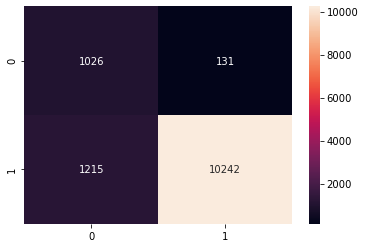

In [20]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
# cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='g')

#### 0=melanogaster, 1=suzukii, 2=zaprionus

In [13]:
pd.Series(y_test).value_counts()

1    11457
0     1157
dtype: int64

In [14]:
y_pred = np.argmax(pred, axis=1)

sub = pd.concat([pd.Series(y_test), pd.Series(X_test)], axis=1)
sub['preds'] = y_pred
sub.columns = ['labels','fnames','preds']
sub['datestr'] = get_wingbeat_dates(sub.fnames)[2]

In [15]:
sub.to_csv(f'{TEMP_DATADIR}/df_{model_setting}_{data_setting}_{splitting}.csv', index=False)

### Loading MosquitoNet and removing its last 2 layers

In [ ]:
merged = False

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f"FliesTL_{data_setting}_{model_setting}_{splitting}_merged{merged}"
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=3).config
else:
    modelname = f"FliesTL_{data_setting}_{model_setting}_{splitting}_merged{merged}"
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config

model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# NOT LOADING MODELS
model.summary()

if data_setting in ['raw', 'rawflt','psd','psdflt', 'psd_dB','psd_dBflt']:
    # cut_mosquito_model is the model without its last dropout and softmax
    cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
elif data_setting in ['stft','stftflt']:
    cut_mosquito_model = Model(model.inputs, model.layers[-2].output)

In [ ]:
input_shape=cut_mosquito_model.output_shape[1:]

### Creating a shallow model to put on top of Mosquito model
top_model = Sequential()
top_model.add(Flatten(input_shape=input_shape))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
Xf_xtracted_train = cut_mosquito_model.predict(valid_generator(X_train, 
                                                y_train, 
                                                batch_size=128, 
                                                setting=data_setting, 
                                                preprocessing_train_stats='',
                                                target_names=np.unique(y_test).tolist()),
                                            steps = int(math.ceil(float(len(X_train)) / float(128))))

Xf_xtracted_val = cut_mosquito_model.predict(valid_generator(X_val, 
                                                y_val, 
                                                batch_size=128, 
                                                preprocessing_train_stats='',
                                                setting=data_setting, 
                                                target_names=np.unique(y_test).tolist()),
                                            steps = int(math.ceil(float(len(X_val)) / float(128))))    

In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(3)}

### Training Shallow model for a few epochs
traincf_flies = TrainConfiguration(nb_classes=3, setting='rawflt', monitor='val_accuracy', 
                                   model_name=f'top_model_flies', batch_size=32, epochs=10)

In [ ]:
from tensorflow.keras.utils import to_categorical

top_model.fit(Xf_xtracted_train, to_categorical(y_train, num_classes=3), 
              validation_data=(Xf_xtracted_val,to_categorical(y_val, num_classes=3)),
              batch_size=traincf_flies.batch_size, 
              epochs=traincf_flies.epochs, 
              callbacks=traincf_flies.callbacks_list,
             class_weight=class_weights,
             verbose=1);

In [ ]:
### Adding shallow model on top of the cut Mosquito model
inputA = Input(cut_mosquito_model.input_shape[1:])
outputA = cut_mosquito_model(inputA)
outputB = top_model(outputA)
modelC = Model(inputA, outputB)
modelC.compile(loss='categorical_crossentropy',
              optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
### Training MosquitoNet+Shallow
traincf_flies = TrainConfiguration(nb_classes=3, setting=data_setting, monitor='val_accuracy', model_name=f'whole_model_flies', batch_size=32)
h = modelC.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf_flies.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    preprocessing_train_stats='',
                                    setting=traincf_flies.setting),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf_flies.batch_size))),
                    epochs = traincf_flies.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf_flies.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        preprocessing_train_stats='',
                                                        setting=traincf_flies.setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf_flies.batch_size))),
                    callbacks=traincf_flies.callbacks_list, 
                    class_weight=class_weights, 
                    verbose=1);

yf_pred = modelC.predict(valid_generator(X_test, 
                        y_test, 
                        batch_size=128, 
                        setting=data_setting, 
                         preprocessing_train_stats='',
                        target_names=np.unique(y_test).tolist()),
                    steps = int(math.ceil(float(len(X_test)) / float(128))))

In [ ]:
balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(yf_pred, axis=1))